In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import Lasso, Ridge

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [55]:
data_pd = pd.read_csv('final_df_new.csv')
data_pd = data_pd.fillna(0)

data_pd = pd.get_dummies(data_pd, columns=['Pos'])
data_pd = pd.get_dummies(data_pd, columns=['League'])

train_df, test_df = train_test_split(data_pd, test_size=0.5)

dropped_columns = ['Unnamed: 0', 'Player', 'Nation', 'Squad', '90s', 'Market Value']

In [56]:
data_pd['CountryESP'] = (data_pd['Nation'] == 'ESP').astype(int)
data_pd['CountryENG'] = (data_pd['Nation'] == 'ENG').astype(int)
data_pd['CountryOther'] = ((data_pd['Nation'] != 'ESP') & (data_pd['Nation'] != 'ENG')).astype(int)

In [57]:
from collections import Counter
Counter(data_pd['Nation']).most_common()[0:2]

[('ESP', 179), ('ENG', 112)]

In [58]:
train_df_dropped_cols = train_df.drop(dropped_columns, axis=1)
train_arr = train_df_dropped_cols.to_numpy()
test_df_dropped_cols = test_df.drop(dropped_columns, axis=1)
test_arr = test_df_dropped_cols.to_numpy()

train_features_sc = StandardScaler()
train_features_norm = train_features_sc.fit_transform(train_arr)
#data2 = data.copy()
test_features_norm = train_features_sc.transform(test_arr)

train_mktval = train_df['Market Value'].to_numpy().reshape(-1, 1)
test_mktval = test_df['Market Value'].to_numpy().reshape(-1, 1)
train_mktval_sc = StandardScaler()
train_mktval_norm = train_mktval_sc.fit_transform(train_mktval)
test_mktval_norm = train_mktval_sc.transform(test_mktval)

#(train_features_norm, test_features_norm, train_mktval_norm, test_mktval_norm)

In [59]:
num_components = 25

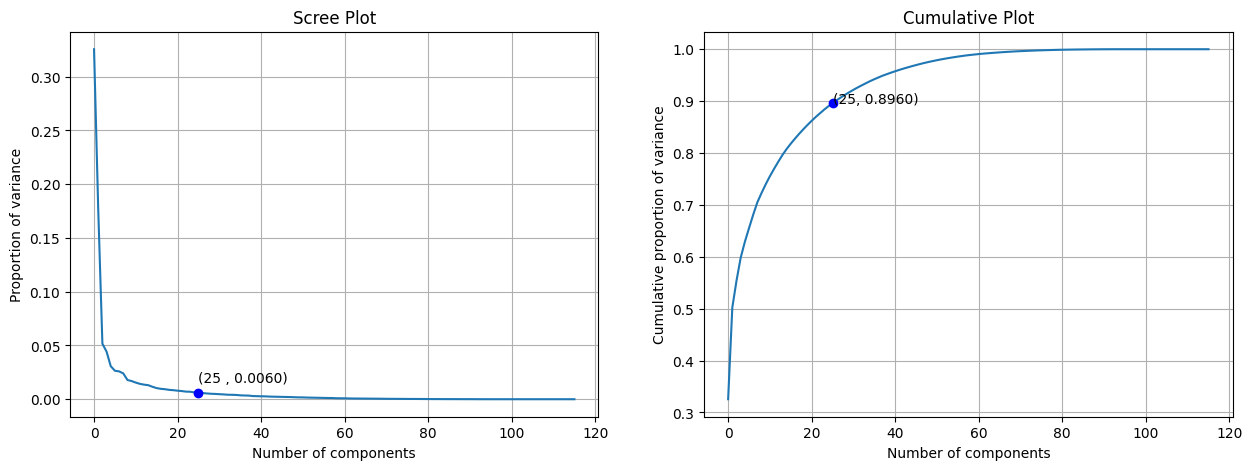

In [60]:
pca = PCA()
pca.fit(train_features_norm)
fig, axs = plt.subplots(1,2, figsize=(15, 5))
axs[0].plot(pca.explained_variance_ratio_[:])
# scree plot
axs[0].set_title('Scree Plot')
axs[0].set_xlabel('Number of components')
axs[0].set_ylabel('Proportion of variance')
axs[0].text(num_components,
            pca.explained_variance_ratio_[num_components]+0.01,
            f'({num_components} , {pca.explained_variance_ratio_[num_components]:.4f})')
axs[0].plot(num_components, pca.explained_variance_ratio_[num_components], 'bo')
axs[0].grid(True)

c_sum = np.cumsum(pca.explained_variance_ratio_)
axs[1].plot(c_sum)
axs[1].set_title('Cumulative Plot')
axs[1].set_xlabel('Number of components')
axs[1].set_ylabel('Cumulative proportion of variance')
axs[1].text(num_components, c_sum[num_components], f'({num_components}, {c_sum[num_components]:.4f})')
axs[1].plot(num_components, c_sum[num_components], 'bo')
axs[1].grid(True)


In [61]:
for i in range(5):
    sorted_pca = np.argsort(pca.components_[i])[-5:][::-1]
    cols_upper = []
    for a1 in sorted_pca:
        cols_upper.append(train_df_dropped_cols.columns[a1])
    print(cols_upper)

    sorted_pca = np.argsort(pca.components_[i])[:5]
    cols_lower = []
    for a1 in sorted_pca:
        cols_lower.append(train_df_dropped_cols.columns[a1])
    print(cols_lower)
    print()

['Touches_Touches', 'Touches_Live', 'Performance_Recov', 'Receiving_Rec', 'Carries_Carries']
['Pos_FW', 'Standard_Sh/90', 'Take-Ons_Tkld%', 'League_La Liga', 'Expected_A-xAG']

['Standard_SoT', 'Standard_SoT/90', 'Touches_Att Pen', 'Expected_npxG', 'Expected_xG']
['Touches_Def 3rd', 'Touches_Def Pen', 'Clr', 'Blocks_Sh', 'Pos_DF']

['Aerial Duels_Won', 'Aerial Duels_Lost', 'Expected_npxG', 'Expected_npxG/Sh', 'Expected_xG']
['Performance_Crs', 'SCA Types_PassDead', 'CrsPA', 'GCA Types_PassDead', 'SCA_SCA90']

['Tackles_Tkl', 'Tackles_TklW', 'Performance_TklW', 'Tackles_Mid 3rd', 'Challenges_Att']
['Standard_PKatt', 'Standard_PK', 'Standard_FK', 'SCA Types_PassDead', 'Medium_Cmp']

['Expected_np:G-xG', 'Expected_G-xG', 'Standard_G/Sh', 'Standard_G/SoT', 'Total_Cmp%']
['Age', 'Aerial Duels_Lost', 'Aerial Duels_Won', 'Performance_Crs', 'Performance_Off']



Text(0, 0.5, 'r2 score')

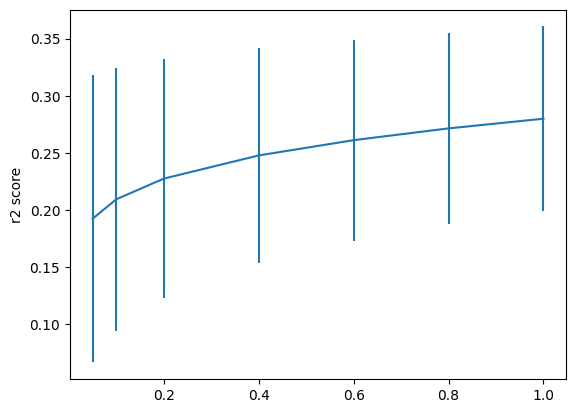

In [62]:
reg = Ridge(random_state=123, max_iter=100)
alpha_vals = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
grid_search = GridSearchCV(reg, param_grid={'alpha':alpha_vals},cv=5)
cv = grid_search.fit(train_features_norm, train_mktval_norm)
results_pd = pd.DataFrame(cv.cv_results_)
scores = results_pd['mean_test_score']
scores_std = results_pd['std_test_score']
plt.errorbar(alpha_vals, scores, scores_std)
plt.ylabel('r2 score')

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12 stored elements and shape (1, 116)>

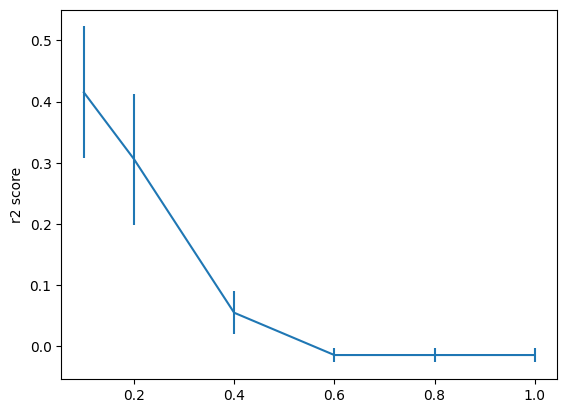

In [63]:
reg = Lasso(random_state=123, max_iter=100)
alpha_vals = [0.1, 0.2, 0.4, 0.6, 0.8, 1]
grid_search = GridSearchCV(reg, param_grid={'alpha':alpha_vals},cv=5)
cv = grid_search.fit(train_features_norm, train_mktval_norm)
results_pd = pd.DataFrame(cv.cv_results_)
scores = results_pd['mean_test_score']
scores_std = results_pd['std_test_score']
plt.errorbar(alpha_vals, scores, scores_std)
plt.ylabel('r2 score')
best_model = cv.best_estimator_
best_model.sparse_coef_

In [64]:
for i in range(len(train_df_dropped_cols.columns)):
    if best_model.coef_[i]!=0:
        print(train_df_dropped_cols.columns[i], best_model.coef_[i])

Age -0.20607864336905374
Standard_Gls 0.15335706000022387
Expected_xG 0.20723527449805418
Total_Cmp% 0.04081594981663369
Short_Cmp 0.061137143934402845
Long_Cmp% 0.03356503542669665
1/3 0.07780370752620286
SCA Types_Def 0.03630029846510859
GCA_GCA 0.02567687931048819
Carries_PrgDist 0.06639546825523483
League_EPL 0.19001538969308598
League_La Liga -8.136860361123726e-16


In [65]:
test_score = best_model.score(test_features_norm, test_mktval_norm)
print(test_score)

0.4707237981969046


In [66]:
train_df_dropped_cols.columns

Index(['Age', 'Standard_Gls', 'Standard_Sh', 'Standard_SoT', 'Standard_SoT%',
       'Standard_Sh/90', 'Standard_SoT/90', 'Standard_G/Sh', 'Standard_G/SoT',
       'Standard_Dist',
       ...
       'Performance_OG', 'Performance_Recov', 'Aerial Duels_Won',
       'Aerial Duels_Lost', 'Aerial Duels_Won%', 'Pos_DF', 'Pos_FW', 'Pos_MF',
       'League_EPL', 'League_La Liga'],
      dtype='object', length=116)

In [67]:
transformed_features_train = pca.transform(train_features_norm)[:,:num_components]
transformed_features_test = pca.transform(test_features_norm)[:,:num_components]

In [68]:
transformed_features_test.shape

(310, 25)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10 stored elements and shape (1, 25)>

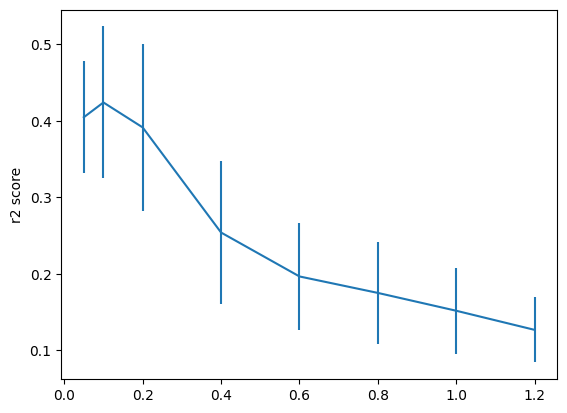

In [69]:
reg = Lasso(random_state=123, max_iter=100)
alpha_vals = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2]
grid_search = GridSearchCV(reg, param_grid={'alpha':alpha_vals},cv=5)
cv = grid_search.fit(transformed_features_train, train_mktval_norm)
results_pd = pd.DataFrame(cv.cv_results_)
scores = results_pd['mean_test_score']
scores_std = results_pd['std_test_score']
plt.errorbar(alpha_vals, scores, scores_std)
plt.ylabel('r2 score')
best_model = cv.best_estimator_
best_model.sparse_coef_

Text(0, 0.5, 'r2 score')

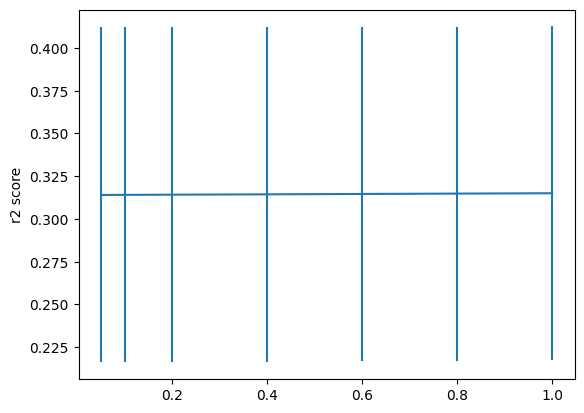

In [70]:
reg = Ridge(random_state=123, max_iter=100)
alpha_vals = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
grid_search = GridSearchCV(reg, param_grid={'alpha':alpha_vals},cv=5)
cv = grid_search.fit(transformed_features_train, train_mktval_norm)
results_pd = pd.DataFrame(cv.cv_results_)
scores = results_pd['mean_test_score']
scores_std = results_pd['std_test_score']
plt.errorbar(alpha_vals, scores, scores_std)
plt.ylabel('r2 score')

In [72]:
out = best_model.predict(transformed_features_test)
print(root_mean_squared_error(test_mktval_norm, out))
out = best_model.predict(transformed_features_train)
print(root_mean_squared_error(train_mktval_norm, out))

0.9103630025396238
0.7223618186579038
